In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils import shuffle
from collections import defaultdict
import seaborn as sb
from scipy import stats
from sklearn import preprocessing
import sys
import win32com.client
from tempfile import NamedTemporaryFile 
import os

In [ ]:
def cv_indexes(dataframe, split_num):
    shape = dataframe.shape                    # find no. rows and columns in input dataframe.
    grp_size = shape[0]/split_num              # find size of folds based on dataframe size and desired split number.
    count = 0
    indexes = []
    for i in range(split_num):                 # count through the desired number of splits.
        indexes.append([int(count), int(count + grp_size)]) # indexes will reflect the start and end of each fold.
        count = count + grp_size
    indexes[-1][1] = indexes[-1][1] - 1 # index starts at zero so need to be cautious and avoid index errors by shortening final
    return indexes                      # index. 

def hill_climb_boost(dataframe, pred_name, fold_num, stepsize, max_iter, learn_rate, no_estimators):
    features = dataframe.drop(pred_name, axis = 1) # extract out features.
    predictor = dataframe[pred_name]               # extract out variable that is being predicted.
    learner_rate = learn_rate
    num_estimators = no_estimators
    errorlist = []                                 # this list will store error rate from each CV cycle to give a mean.
    indexes = cv_indexes(dataframe, fold_num)      # apply cross validation to proide indexes for partitioning.
    for j in indexes:                              # loop through each CV index.
        print('indexes:', j)
        testfeats = features.iloc[j[0]:j[1]]       # extract out testing features from total features for each CV split index.
        testpreds = predictor.iloc[j[0]:j[1]]      # extract out associated testing predicttion variables.
        trainfeats1 = features.iloc[0:j[0]]        # extract out lower portion of training features.
        trainfeats2 = features.iloc[j[1]:features.shape[0]] # extract out upper portion of training features.
        trainfeats = pd.concat([trainfeats1, trainfeats2]) # concatenate upper and lower to give full training features.
        trainpreds1 = predictor.iloc[0:j[0]]       # extract out associated prediction variable values.
        trainpreds2 = predictor.iloc[j[1]:features.shape[0]] 
        trainpreds = pd.concat([trainpreds1, trainpreds2])  # again, concatenate upper and lower. 
        model = GradientBoostingClassifier(learning_rate = learn_rate, n_estimators = no_estimators) # generate initial model.
        model.fit(trainfeats,trainpreds) # fit to the training data.
        predictions = model.predict(testfeats) # generate predictions from the test features.
        errorhold = 0
        for k in range(len(predictions)): # loop through the predictions and results.
            if predictions[k] != testpreds.iloc[k]: # if they don't match, add 1 to the error count. 
                errorhold = errorhold + 1
        errorlist.append(errorhold)          # append error count from each cross validation.
    print('initial error:', np.mean(errorlist)) # output error is the average error from the list.
    error = np.mean(errorlist)
    longjump = False
    noimprovtime = 0
    for i in range(max_iter):
        noimprovtime = noimprovtime + 1
        feat = random.randint(0,1) # randomly choose which parameter to modify.
        feat_change = random.randint(0-stepsize, stepsize) # randomly generate a step size.
        if feat == 0:
            new_learn_rate = learner_rate + feat_change/90 # modify the current parameter value based on step size.
            if new_learn_rate > 0:
                model = GradientBoostingClassifier(learning_rate = new_learn_rate, n_estimators = num_estimators) # fit new model
                #print('current parameter values:', new_learn_rate, num_estimators)
            else:    # learn rate can't be less than zero - exception case.
                model = GradientBoostingClassifier(learning_rate = learner_rate + 0.2, n_estimators = num_estimators) 
                #print('current parameter values:', learner_rate, num_estimators)
        elif feat == 1:
            new_no_estimators = num_estimators + feat_change # again, modify current parameter. 
            if new_no_estimators > 0:
                model = GradientBoostingClassifier(learning_rate = learner_rate, n_estimators = new_no_estimators)
                #print('current parameter values:', learner_rate, new_no_estimators)
            elif new_no_estimators < 0.5:
                model = GradientBoostingClassifier(learning_rate = learner_rate, n_estimators = new_no_estimators)
                #print('current parameter values:', learner_rate, new_no_estimators)
        errorlist = [] # initialise a new error list.
        
        for l in indexes:
            testfeats = features.iloc[l[0]:l[1]] # extract out training and testing data as before.
            testpreds = predictor.iloc[l[0]:l[1]]
            trainfeats1 = features.iloc[0:l[0]]
            trainfeats2 = features.iloc[l[1]:features.shape[0]]
            trainfeats = pd.concat([trainfeats1, trainfeats2])
            trainpreds1 = predictor.iloc[0:l[0]]
            trainpreds2 = predictor.iloc[l[1]:features.shape[0]] 
            trainpreds = pd.concat([trainpreds1, trainpreds2]) 
            model.fit(trainfeats, trainpreds) # fit the new model to the training data.
            predictions = model.predict(testfeats) # generate predictions from the new model.
            errorhold = 0
            for m in range(len(predictions)): # generate error count as before and append to errorlist.
                if predictions[m] != testpreds.iloc[m]:
                    errorhold = errorhold + 1
            errorlist.append(errorhold)
        if feat == 0 and np.mean(errorlist) < error: # if the new error is smaller than current error, permanently change 
            error = np.mean(errorlist)               # parameter values and error variable. 
            learner_rate = new_learn_rate
            print('current error:', np.mean(errorlist))
            noimprovtime = 0
            prejumpvals = [learner_rate,num_estimators, 100 - ((error/(dataframe.shape[0]/fold_num))*100)]
        elif feat == 1 and np.mean(errorlist) < error: # again, change error and parameter value.
            error = np.mean(errorlist)
            num_estimators = new_no_estimators
            print('current error:', np.mean(errorlist))
            noimprovtime = 0
            prejumpvals = [learner_rate, num_estimators, 100 - ((error/(dataframe.shape[0]/fold_num))*100)]
        if longjump == False:
            if noimprovtime > max_iter/5:     # if no improvements have been made for ages, jump to a new location in space.
                learner_rate = abs(random.uniform(0, int(learner_rate+1)))
                num_estimators = abs(random.randint(int(num_estimators-5), int(num_estimators+5)))+1
                longjump = True       # tell the code that a long jump has occured.
                print('switched')     # show the user that a jump has occurred.
                noimprovtime = 0      # reset noimprovtime to stop longjumping. 
        elif longjump == True:
            if noimprovtime > max_iter/10: # if there has already been a jump and no imporvements have been made for ages:
                learner_rate = abs(random.uniform(0, int(learner_rate+1)))   # jump again.
                num_estimators = int(abs(random.randint(int(num_estimators-5), int(num_estimators+5))))+1
                longjump = True
                print('switched')
                noimprovtime = 0   # reset to avoid continous jumping. 
                
    return (100 - ((error/(dataframe.shape[0]/fold_num))*100), learner_rate, num_estimators, prejumpvals) # return output

In [2]:
xlApp = win32com.client.Dispatch("Excel.Application") # opening a password protected file requires a special procedure 
data = xlApp.Workbooks.Open('data16032019 finalversion', 2, True, True, None, '******') # need to build a workbook (xlsx) to 
                                                                                        # apply the password. 
f = NamedTemporaryFile(delete=False, suffix='.csv')  
f.close()
os.unlink(f.name)  

xlCSVWindows = 0x17  
data.SaveAs(Filename=f.name, FileFormat=xlCSVWindows)  
df = pd.read_csv(f.name)                                       # read the opened data into a pandas datframe.

In [3]:
newdf = df[['AA Change', 'Diagnosis', 'Family history (y/n)', 'Age onset (years)', 'symptom onset - date diagnosis (months)', 
           'disease duration (months onset to death/censor)', 'Site onset', 'Dementia (y/n)']] # extract out variables of interest.
nodemdf = newdf.drop('Dementia (y/n)', axis = 1) # dementia columns has too much missing data.
nodemdf['disease duration (months onset to death/censor)'] = nodemdf['disease duration (months onset to death/censor)'].fillna(value = -1)
binlist = []                                                        # replace duration nans with a numerical value (currently str)
count = 0
for i in range(nodemdf.shape[0]):   # loop through survival times to assign each patient to their bin.
    if nodemdf['disease duration (months onset to death/censor)'].iloc[i] != 'n/a': 
        if float(nodemdf['disease duration (months onset to death/censor)'].iloc[i]) < 0:
            binlist.append(-1)
        if 0 < float(nodemdf['disease duration (months onset to death/censor)'].iloc[i]) <= 24:
            binlist.append(0)
            count = count + 1
        elif 24 < float(nodemdf['disease duration (months onset to death/censor)'].iloc[i]) <= 60:
            binlist.append(1)
        elif 60 < float(nodemdf['disease duration (months onset to death/censor)'].iloc[i]):
            binlist.append(2)
    elif nodemdf['disease duration (months onset to death/censor)'].iloc[i] == 'n/a' or nodemdf['disease duration (months onset to death/censor)'].iloc[i].isnull():
        binlist.append(-1)
nodemdf['survival_bin'] = binlist # add the list of bins as a new feature
nodemdf = nodemdf.drop('disease duration (months onset to death/censor)', axis = 1) # drop survival in months columns.
nonandf = nodemdf.drop(['Site onset', 'Diagnosis'], axis = 1).dropna() # remove columns that have too much missing data. 
newnonandf = nonandf.replace('n/a', '-1')
newerdf = (newnonandf[newnonandf['survival_bin'] > -0.5])
newestdf = newerdf.apply(preprocessing.LabelEncoder().fit_transform)
#hill_climb_boost(newestdf, 'survival_bin', 3, 4, 50, 0.15, 27)

accuracy: 52.17391304347826


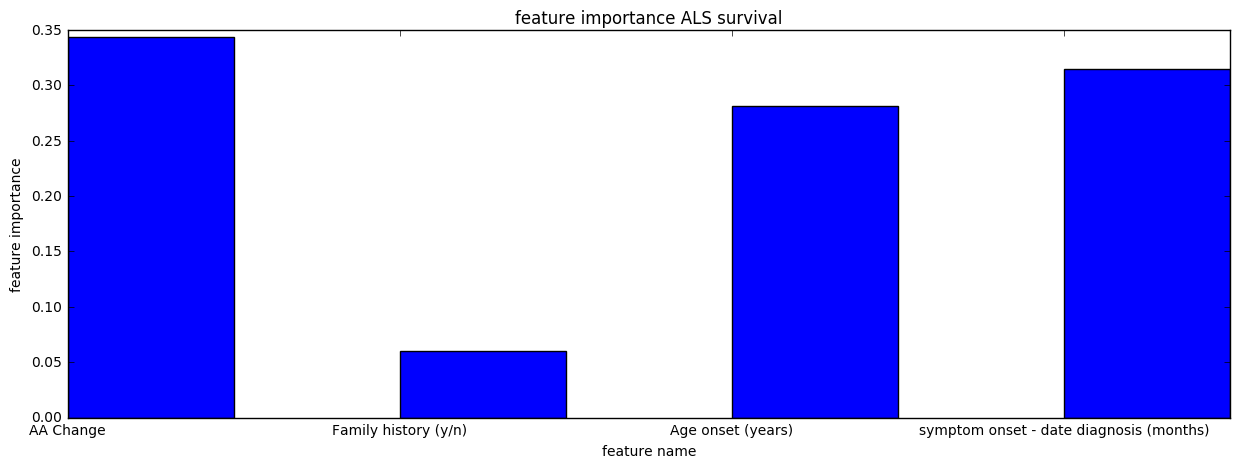

In [7]:
model = GradientBoostingClassifier(learning_rate = 0.9, n_estimators = 33) # establish a gradietn boosting model. 
traindf = newestdf[:84]      # establish a training and test set. 
testdf = newestdf[84:]
model.fit(traindf.drop('survival_bin', axis = 1), traindf['survival_bin']) # fit the model to training set. 
predictions = model.predict(testdf.drop('survival_bin', axis = 1)) # generate a set of predictions from the test set. 
error = 0
bin_density = defaultdict(int)
bin_error = defaultdict(int)
confusion = defaultdict(int)
for y in range(len(predictions)):
    if predictions[y] != testdf['survival_bin'].iloc[y]:
        error = error + 1
        bin_error[testdf['survival_bin'].iloc[y]] = bin_error[testdf['survival_bin'].iloc[y]] + 1 # count errors per bin.
    bin_density[testdf['survival_bin'].iloc[y]] = bin_density[testdf['survival_bin'].iloc[y]] + 1 # count bin size.
    confusion[str(testdf['survival_bin'].iloc[y]) + str(predictions[y])] = confusion[str(testdf['survival_bin'].iloc[y]) + 
                                                                                     str(predictions[y]) ] + 1
                                                       # count number of miclassifications between groups (for confusion matrix)
print('accuracy:', 100 - ((error/testdf.shape[0]) * 100)) # find true positive accuracy, for whole dataset. 
importance = model.feature_importances_ # extract feature importances from the model.
newimportance = []
plt.figure(figsize = (15,5))  # plot the feature importances as a bar chart.
plt.bar(range(len(importance)), importance, width = 0.5, tick_label = list(traindf.drop('survival_bin', axis = 1).columns.values))
plt.title('feature importance ALS survival')
plt.ylabel('feature importance')
plt.xlabel('feature name')
plt.show()

In [ ]:
for key, value in bin_density.items():                                  # find the numbers of each bin, needed for normalisation
    print('class:', key, '   number of this class in test set:', value)
for key, value in bin_error.items():
    print('class:', key, '   number of errors for this class:', value)

print('\n')
print('relative class errors:')
for key,value in bin_density.items():
    print(value)
    print('class: ', key, '   relative error:', (bin_error[key]/value)*100)    # normalise error based on class size.
confusion_mat = np.zeros((3,3))    # establish an empty matrix that will become the confusion matrix.
print('\n')
print('key[0] = real, key[1] = predicted:')
for key,value in confusion.items():
    print(key, value)                                  # 'confusion' contains true positive and misclassifications. 
    confusion_mat[int(key[0])][int(key[1])] = value    # construct the confusion matrix based on values in confusion dict.
confusion_mat[0] = confusion_mat[0]/4                  # divide the scores for each confusion entry based on number of samples.
confusion_mat[1] = confusion_mat[1]/4
confusion_mat[2] = confusion_mat[2]/9
sb.heatmap(confusion_mat, cmap = 'YlGnBu', annot = True) # build heatmap of confusion matrix using seaborn. 
plt.ylabel('real class')
plt.xlabel('predicted class')
plt.title('confusion matrix')
plt.show()